# WFC地图生成器 - 基于散度目标

这个notebook可以根据指定的CS散度值生成不同复杂度的地图：
- **简单地图**: CS散度 0 - 0.1 (平坦，少变化)
- **复杂地图**: CS散度 0.6 - 1.0 (多样化，高复杂度)

使用散度递增策略，自动找到更复杂的地图作为种子，提高搜索效率。

## 1. 初始化

导入必要的库和模块，设置WFC和Unity环境

In [1]:
import numpy as np
from scipy.stats import entropy
from map2graph import map2digraph, get_map_shortest_length_dist, tiles2data
from utils import cs_divergence, tilemap2heightmap, tileid_to_json
import fastwfc
import matplotlib.pyplot as plt
import matplotlib
import random
from datetime import datetime
import os
import cv2
from utils import json_to_tileid
from WFCUnity3DEnv_fastwfc import WFCUnity3DEnv

# 设置字体 - 使用英文字体避免中文字体问题
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 初始化WFC和Unity环境
print("正在初始化WFC和Unity环境...")
wfc = fastwfc.XLandWFC("samples.xml")
file_name = "/home/yinzi/Downloads/fast_wfc_map/fastwfc_map.x86_64"
wfc_unity = WFCUnity3DEnv(file_name=file_name)

# 创建统一的输出目录结构
BASE_OUTPUT_DIR = "wfc_generated_maps"
def setup_output_directories():
    """创建输出目录结构"""
    dirs = [
        f"{BASE_OUTPUT_DIR}/simple_maps",           # 简单地图 (0-0.1)
        f"{BASE_OUTPUT_DIR}/medium_maps",           # 中等地图 (0.5-0.7)
        f"{BASE_OUTPUT_DIR}/complex_maps",          # 复杂地图 (0.8-1.0)
        f"{BASE_OUTPUT_DIR}/session_logs"           # 会话日志
    ]
    
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"✓ 创建目录: {dir_path}")
    
    return dirs

# 设置输出目录
output_dirs = setup_output_directories()

def get_map_category_and_dir(target_cs_divergence):
    """根据目标散度确定地图类别和输出目录"""
    if 0 <= target_cs_divergence <= 0.1:
        return "simple", f"{BASE_OUTPUT_DIR}/simple_maps"
    elif 0.5 <= target_cs_divergence <= 0.7:
        return "medium", f"{BASE_OUTPUT_DIR}/medium_maps"
    elif 0.8 <= target_cs_divergence <= 1.0:
        return "complex", f"{BASE_OUTPUT_DIR}/complex_maps"
    else:
        return "other", f"{BASE_OUTPUT_DIR}/simple_maps"  # 默认归类到简单地图

def generate_target_divergence_map(target_cs_divergence=0.2, max_iters=1000, 
                                 mutation_weight=162, tolerance=0.05):
    """
    生成指定CS散度的地图
    
    Args:
        target_cs_divergence: 目标CS散度值
        max_iters: 最大迭代次数
        mutation_weight: 变异权重
        tolerance: 容差
    
    Returns:
        符合条件的地图数据
    """
    # 确定地图类别和保存目录
    map_category, save_dir = get_map_category_and_dir(target_cs_divergence)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 根据目标复杂度选择初始地图策略
    if target_cs_divergence > 0.5:
        print(f"目标复杂度 {target_cs_divergence} > 0.5，从随机地图开始")
        # 从随机生成的地图开始
        ids, _ = wfc.generate(out_img=False)
        base_wave = wfc.wave_from_id(ids)
        start_method = "random"
        print("✓ 使用随机生成的地图作为起点")
    else:
        print(f"目标复杂度 {target_cs_divergence} ≤ 0.5，从空地开始")
        # 从空地开始
        base_wave = wfc.build_a_open_area_wave()
        ids = wfc.get_ids_from_wave(base_wave)
        start_method = "empty"
        print("✓ 使用空地作为起点")
    
    # 计算初始距离分布
    DG = map2digraph(tiles2data(ids))
    dist1 = get_map_shortest_length_dist(DG, norm=False)
    
    # 计算初始散度
    empty_wave = wfc.build_a_open_area_wave()
    empty_ids = wfc.get_ids_from_wave(empty_wave)
    empty_DG = map2digraph(tiles2data(empty_ids))
    empty_dist = get_map_shortest_length_dist(empty_DG, norm=False)
    initial_cs_divergence = cs_divergence(empty_dist, dist1)
    
    iteration = 0
    current_cs_divergence = initial_cs_divergence
    
    print(f"Map category: {map_category.upper()}")
    print(f"Target CS divergence: {target_cs_divergence}")
    print(f"Initial CS divergence: {initial_cs_divergence:.4f}")
    print(f"Search tolerance: ±{tolerance}")
    print(f"Output directory: {save_dir}")
    print("Starting search...")
    print("-" * 40)
    
    while iteration < max_iters:
        # 生成变异地图
        new_ids, img_basic = wfc.mutate(base_wave=base_wave, new_weight=mutation_weight, 
                                       iter_count=1, out_img=True)
        new_wave = wfc.wave_from_id(new_ids)
        
        # 计算新的距离分布
        DG2 = map2digraph(tiles2data(new_ids))
        dist2 = get_map_shortest_length_dist(DG2, norm=False)
        
        # 检查高度层数
        height_map = tilemap2heightmap(new_ids)
        unique_layers = len(np.bincount(height_map))
        
        # 计算CS散度 (相对于空地)
        cs_div = cs_divergence(empty_dist, dist2)
        
        # 检查散度是否递增
        divergence_increased = cs_div > current_cs_divergence
        
        # 检查是否符合目标散度
        cs_diff = abs(cs_div - target_cs_divergence)
        valid_divergence = (cs_div > 0.0 and cs_diff <= tolerance)
        
        # 如果散度递增，更新种子
        if divergence_increased:
            print(f"Iter {iteration}: Divergence increased {current_cs_divergence:.4f} → {cs_div:.4f}")
            current_cs_divergence = cs_div
            dist1 = dist2
            base_wave = new_wave
        
        # 找到符合条件的地图
        if valid_divergence:
            print(f"✓ Found matching {map_category} map! (iteration {iteration})")
            print(f"  CS divergence: {cs_div:.4f} (target: {target_cs_divergence:.4f})")
            print(f"  Height layers: {unique_layers}")
            
            # Unity渲染
            try:
                wfc_unity.set_wave(new_ids)
                img_unity = wfc_unity.render_in_unity()
                
                # 保存结果
                result = {
                    'iteration': iteration,
                    'cs_divergence': cs_div,
                    'layers': unique_layers,
                    'map_ids': new_ids,
                    'wave': new_wave,
                    'basic_image': img_basic,
                    'unity_image': img_unity,
                    'timestamp': timestamp,
                    'initial_divergence': initial_cs_divergence,
                    'start_method': start_method,
                    'map_category': map_category,
                    'save_directory': save_dir
                }
                
                # 保存文件 - 统一命名格式
                save_path_prefix = f"{save_dir}/{map_category}_{timestamp}_{start_method}_div_{cs_div:.4f}"
                tileid_to_json(new_ids, f"{save_path_prefix}_data.json")
                
                img_bgr = cv2.cvtColor(img_basic, cv2.COLOR_RGB2BGR)
                cv2.imwrite(f"{save_path_prefix}_basic.png", img_bgr)
                
                if img_unity is not None:
                    img_unity_bgr = cv2.cvtColor((img_unity * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    cv2.imwrite(f"{save_path_prefix}_unity.png", img_unity_bgr)
                
                # 显示结果
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                ax1.imshow(img_basic)
                ax1.set_title(f"Basic WFC Render ({map_category.title()})\nCS Divergence: {cs_div:.4f}, Layers: {unique_layers}")
                ax1.axis('off')
                
                if img_unity is not None:
                    ax2.imshow(img_unity)
                    ax2.set_title(f"Unity 3D Render ({map_category.title()})\nCS Divergence: {cs_div:.4f}, Layers: {unique_layers}")
                    ax2.axis('off')
                else:
                    ax2.text(0.5, 0.5, 'Unity render failed', ha='center', va='center', transform=ax2.transAxes)
                    ax2.axis('off')
                
                plt.tight_layout()
                plt.savefig(f"{save_path_prefix}_comparison.png", dpi=150, bbox_inches='tight')
                plt.show()
                
                print(f"Results saved to: {save_path_prefix}")
                print(f"Category: {map_category} | Start: {start_method} | Initial div: {initial_cs_divergence:.4f}")
                return result
                
            except Exception as e:
                print(f"Unity rendering failed: {e}")
                result['unity_image'] = None
                return result
        
        # 进度提示
        if iteration % 100 == 0 and iteration > 0:
            print(f"Searched {iteration} iterations, current max divergence: {current_cs_divergence:.4f}")
        
        iteration += 1
    
    print(f"Search completed! No {map_category} map found matching target divergence {target_cs_divergence}")
    print(f"Highest divergence reached: {current_cs_divergence:.4f}")
    return None

print("✓ Initialization complete!")
print(f"✓ Output directory structure created under: {BASE_OUTPUT_DIR}/")
print("  - simple_maps/   (CS divergence 0-0.1)")
print("  - medium_maps/   (CS divergence 0.5-0.7)") 
print("  - complex_maps/  (CS divergence 0.8-1.0)")
print("  - session_logs/  (generation logs)")

正在初始化WFC和Unity环境...
Trying to connect to 0.0.0.0:45829
✓ Initialization complete!
✓ Output directory structure created under: wfc_generated_maps/
  - simple_maps/   (CS divergence 0-0.1)
  - medium_maps/   (CS divergence 0.5-0.7)
  - complex_maps/  (CS divergence 0.8-1.0)
  - session_logs/  (generation logs)


## 2. 简单地图生成

生成简单、平坦的地图。请输入**0 到 0.1**之间的CS散度值：
- 0.0: 完全空旷的地图
- 0.05: 少量地形变化
- 0.1: 轻微的复杂度

简单地图生成
目标复杂度 0 ≤ 0.5，从空地开始
✓ 使用空地作为起点
Map category: SIMPLE
Target CS divergence: 0
Initial CS divergence: -0.0000
Search tolerance: ±0.2
Output directory: wfc_generated_maps/simple_maps
Starting search...
----------------------------------------
Iter 2: Divergence increased -0.0000 → 0.1545
✓ Found matching simple map! (iteration 2)
  CS divergence: 0.1545 (target: 0.0000)
  Height layers: 4


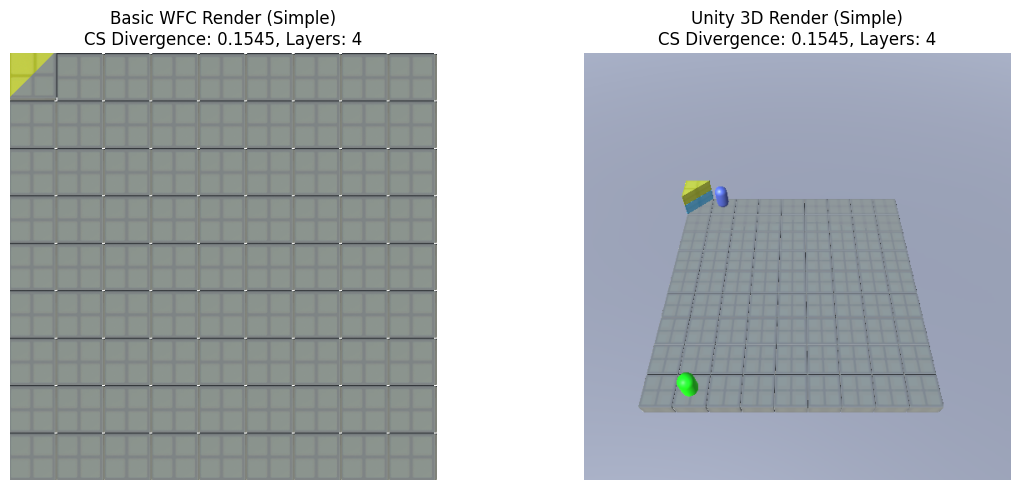

Results saved to: wfc_generated_maps/simple_maps/simple_20250611_025624_empty_div_0.1545
Category: simple | Start: empty | Initial div: -0.0000

✓ 成功生成简单地图!
实际CS散度: 0.1545
高度层数: 4
保存位置: wfc_generated_maps/simple_maps


In [2]:
# 简单地图生成 (CS散度: 0 - 0.1)
# 请修改下面的target_divergence值 (建议: 0.0, 0.05, 0.1)

target_divergence = 0  # 请输入0到0.1之间的值

print("=" * 50)
print("简单地图生成")
print("=" * 50)

if 0 <= target_divergence <= 0.1:
    result = generate_target_divergence_map(
        target_cs_divergence=target_divergence,
        max_iters=300,  # 简单地图通常更容易找到
        mutation_weight=162,
        tolerance=0.2  # 更小的容差确保精确度
    )
    
    if result:
        print(f"\n✓ 成功生成简单地图!")
        print(f"实际CS散度: {result['cs_divergence']:.4f}")
        print(f"高度层数: {result['layers']}")
        print(f"保存位置: {result['save_directory']}")
    else:
        print("\n✗ 未能生成符合条件的简单地图")
else:
    print("❌ 错误：简单地图的CS散度应在0到0.1之间")
    print("请修改 target_divergence 的值")

## 3. 中等难度地图生成

生成中等复杂度的地图。请输入**0.5 到 0.7**之间的CS散度值：
- 0.5: 基础复杂度
- 0.6: 中等复杂度  
- 0.7: 较高复杂度

中等难度地图生成
目标复杂度 0.5 ≤ 0.5，从空地开始
✓ 使用空地作为起点
Map category: MEDIUM
Target CS divergence: 0.5
Initial CS divergence: -0.0000
Search tolerance: ±0.2
Output directory: wfc_generated_maps/medium_maps
Starting search...
----------------------------------------
Iter 2: Divergence increased -0.0000 → 0.0003
Iter 4: Divergence increased 0.0003 → 0.0007
Iter 5: Divergence increased 0.0007 → 0.2124
Iter 10: Divergence increased 0.2124 → 0.2499
Iter 11: Divergence increased 0.2499 → 0.2546
Iter 13: Divergence increased 0.2546 → 0.2586
Iter 14: Divergence increased 0.2586 → 0.2608
Iter 16: Divergence increased 0.2608 → 0.2632
Iter 17: Divergence increased 0.2632 → 0.3183
✓ Found matching medium map! (iteration 17)
  CS divergence: 0.3183 (target: 0.5000)
  Height layers: 6


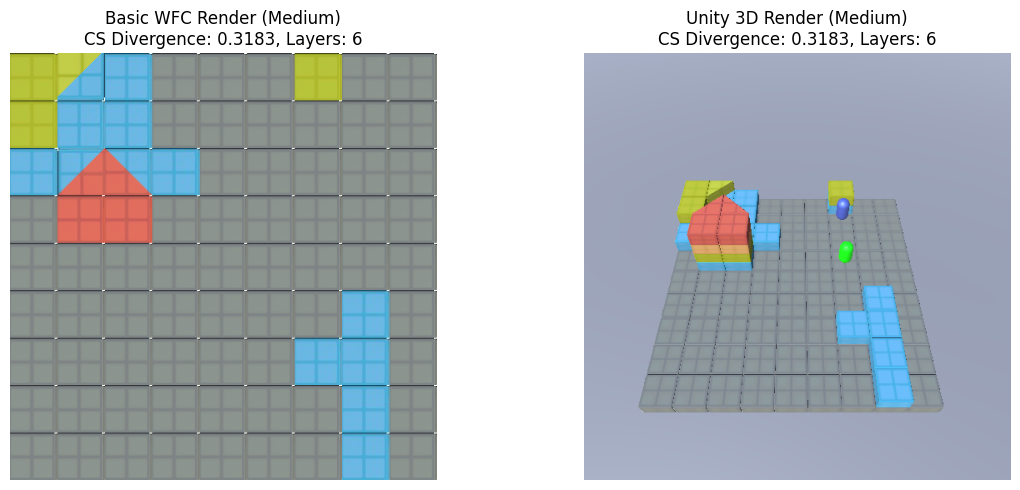

Results saved to: wfc_generated_maps/medium_maps/medium_20250611_025627_empty_div_0.3183
Category: medium | Start: empty | Initial div: -0.0000

✓ 成功生成中等难度地图!
实际CS散度: 0.3183
高度层数: 6
起始方法: empty
搜索迭代次数: 17
保存位置: wfc_generated_maps/medium_maps


In [3]:
# 中等难度地图生成 (CS散度: 0.5 - 0.7)
# 请修改下面的target_divergence值 (建议: 0.5, 0.6, 0.7)

target_divergence = 0.5  # 请输入0.5到0.7之间的值

print("=" * 50)
print("中等难度地图生成")
print("=" * 50)

if 0.5 <= target_divergence <= 0.7:
    result = generate_target_divergence_map(
        target_cs_divergence=target_divergence,
        max_iters=600,  # 中等地图需要适中的搜索时间
        mutation_weight=162,
        tolerance=0.2  # 适中的容差
    )
    
    if result:
        print(f"\n✓ 成功生成中等难度地图!")
        print(f"实际CS散度: {result['cs_divergence']:.4f}")
        print(f"高度层数: {result['layers']}")
        print(f"起始方法: {result['start_method']}")
        print(f"搜索迭代次数: {result['iteration']}")
        print(f"保存位置: {result['save_directory']}")
    else:
        print("\n✗ 未能生成符合条件的中等难度地图")
        print("建议：尝试降低目标散度值或增加max_iters")
else:
    print("❌ 错误：中等难度地图的CS散度应在0.5到0.7之间")
    print("请修改 target_divergence 的值")

## 4. 复杂难度地图生成

生成高复杂度的地图。请输入**0.8 到 1.0**之间的CS散度值：
- 0.8: 高复杂度
- 0.9: 极高复杂度
- 1.0: 最高复杂度 (需要更多搜索时间)

复杂难度地图生成
目标复杂度 1.0 > 0.5，从随机地图开始
✓ 使用随机生成的地图作为起点
Map category: COMPLEX
Target CS divergence: 1.0
Initial CS divergence: 0.4264
Search tolerance: ±0.2
Output directory: wfc_generated_maps/complex_maps
Starting search...
----------------------------------------
Iter 2: Divergence increased 0.4264 → 0.4418
Iter 14: Divergence increased 0.4418 → 0.4491
Iter 19: Divergence increased 0.4491 → 0.4619
Iter 23: Divergence increased 0.4619 → 0.4739
Iter 26: Divergence increased 0.4739 → 0.5205
Iter 29: Divergence increased 0.5205 → 0.5678
Iter 30: Divergence increased 0.5678 → 0.6402
Iter 31: Divergence increased 0.6402 → 0.6825
Iter 40: Divergence increased 0.6825 → 0.6908
Iter 59: Divergence increased 0.6908 → 0.7616
Iter 92: Divergence increased 0.7616 → 0.7679
Searched 100 iterations, current max divergence: 0.7679
Searched 200 iterations, current max divergence: 0.7679
Iter 261: Divergence increased 0.7679 → 0.7736
Iter 287: Divergence increased 0.7736 → 0.7830
Searched 300 iterations, curr

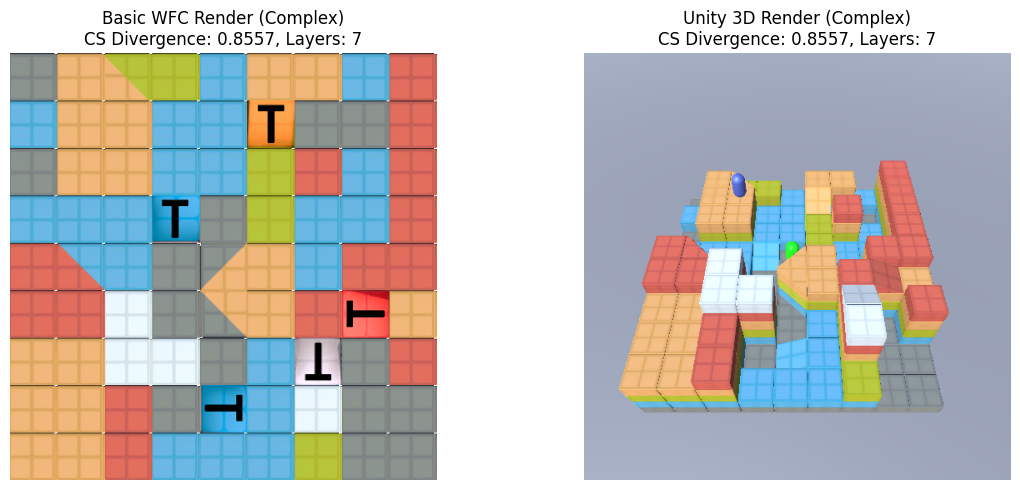

Results saved to: wfc_generated_maps/complex_maps/complex_20250611_025630_random_div_0.8557
Category: complex | Start: random | Initial div: 0.4264

✓ 成功生成复杂难度地图!
实际CS散度: 0.8557
高度层数: 7
起始方法: random
搜索迭代次数: 331
保存位置: wfc_generated_maps/complex_maps


In [4]:
# 复杂难度地图生成 (CS散度: 0.8 - 1.0)
# 请修改下面的target_divergence值 (建议: 0.8, 0.9, 1.0)

target_divergence = 1.0  # 请输入0.8到1.0之间的值

print("=" * 50)
print("复杂难度地图生成")
print("=" * 50)

if 0.8 <= target_divergence <= 1.0:
    result = generate_target_divergence_map(
        target_cs_divergence=target_divergence,
        max_iters=1000,  # 复杂地图需要更多搜索时间
        mutation_weight=162,
        tolerance=0.2  # 适中的容差平衡搜索时间和精度
    )
    
    if result:
        print(f"\n✓ 成功生成复杂难度地图!")
        print(f"实际CS散度: {result['cs_divergence']:.4f}")
        print(f"高度层数: {result['layers']}")
        print(f"起始方法: {result['start_method']}")
        print(f"搜索迭代次数: {result['iteration']}")
        print(f"保存位置: {result['save_directory']}")
    else:
        print("\n✗ 未能生成符合条件的复杂难度地图")
        print("建议：尝试降低目标散度值或增加max_iters")
else:
    print("❌ 错误：复杂难度地图的CS散度应在0.8到1.0之间")
    print("请修改 target_divergence 的值")

## 5. 清理与资源释放

运行完成后，清理Unity3D进程和释放系统资源

In [5]:
# 简化资源清理 - 直接使用 env.close()
print("=" * 50)
print("清理Unity3D环境")
print("=" * 50)

try:
    if 'wfc_unity' in globals():
        print("正在关闭Unity环境...")
        wfc_unity.close()
        print("✓ Unity环境已关闭")
    else:
        print("未找到活跃的Unity环境")
except Exception as e:
    print(f"关闭Unity环境失败: {e}")

# 清理matplotlib图形
try:
    import matplotlib.pyplot as plt
    plt.close('all')
    print("✓ 已关闭所有matplotlib图形")
except Exception as e:
    print(f"关闭matplotlib图形失败: {e}")

print("✓ 清理完成！")
print("=" * 50)

清理Unity3D环境
正在关闭Unity环境...
✓ Unity环境已关闭
✓ 已关闭所有matplotlib图形
✓ 清理完成！
